In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image, display


In [2]:
caminho = ""
#se o inicializar o conda+jupyter pelo terminal:  colocar caminho = "" 
arquivo ="ToolDataSheetVsNQuebras.csv" #<- arquivo a ser utilizado

### Variável dependente (para predição -y-):
*Número de quebras por ano*: `nQuebras`

### Chave primária: 
*código do tipo da ferramenta*:  `PartNumber`

### Variáveis independentes:
*geometria e parâmetros da ferramenta de corte* 

1. `LargerDiameter`
2. `StemDiameter`
3. `TotalLength`
4. `ChannelLength`

In [3]:
# display(Image(caminho+"usinagem_geo.PNG"))

In [4]:
dadosB = None

try:  # carrega dos dados , o separador é ";" pois tem campos na coluna Supplier com ","
    dadosB = pd.read_csv(caminho+arquivo, sep=";")
except IOError as err:
    print (err)

In [5]:
dadosB = dadosB[dadosB.PropellerAngle <= 360] #remove os demais dados incorretos

In [6]:
dadosB.head(1)

,PartNumber,nQuebras,Family,Supplier,LargerDiameter,StemDiameter,TotalLength,ChannelLength,MaterialClass,PropellerAngle,Refrigeration
0,4721700050,5,217-RH,3M TECHNICAL CERAMICS ZWEIGNIEDERLA,3.0,3.0,38.0,2.5,Desconhecido,0.0,0


In [95]:
#requer sklearn:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

def calc_rss(y,predicted):
    return float(((predicted - y) ** 2).sum())


In [96]:
X = dadosB.drop(columns=['nQuebras'])
y = dadosB['nQuebras']
le = preprocessing.LabelEncoder()
# na in Material Class
na_fill = {'MaterialClass': 'na'}
X = X.fillna(value=na_fill)
for col in ['Family', 'Supplier', 'MaterialClass']:
    X[col] = le.fit_transform(X[col])



In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [100]:
reg_grad = SGDRegressor(max_iter=5000)
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# y_scaled = scaler.fit_transform(y.values.ravel())
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size=0.3, random_state=101)
reg_grad.fit(X_train_s,y_train_s.values.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=5000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [101]:
print(r2_score(y_test_s, reg_grad.predict(X_test_s)))
print(mean_squared_error(y_test_s, reg_grad.predict(X_test_s)))
print(calc_rss(y_test_s, reg_grad.predict(X_test_s)))

-2.663272629475968e+46
2.020361306894842e+50
1.333438462550596e+52


In [89]:
for i in range(1,10):
    print('K: {}'.format(i))
    neigh = KNeighborsRegressor(n_neighbors=i).fit(X_train,y_train)
    print(r2_score(y_test, neigh.predict(X_test)))
    print(mean_squared_error(y_test, neigh.predict(X_test)))
    print(calc_rss(y_test, neigh.predict(X_test)))

K: 1
-0.10950846521041524
8416.742424242424
555505.0
K: 2
-0.3687795849616853
10383.575757575758
685316.0
K: 3
-0.1787350008543993
8941.895622895623
590165.1111111111
K: 4
-0.1281454930993391
8558.123106060606
564836.125
K: 5
-0.06372346757388381
8069.416969696972
532581.5200000001
K: 6
-0.08057900530171391
8197.283249158249
541020.6944444444
K: 7
-0.13867222141681212
8637.978973407548
570106.6122448981
K: 8
-0.12649847206780174
8545.628787878788
564011.5
K: 9
-0.11962637724107217
8493.497007108119
560570.8024691358


In [90]:
tree = DecisionTreeRegressor().fit(X_train,y_train)
print(r2_score(y_test, tree.predict(X_test)))
print(mean_squared_error(y_test, tree.predict(X_test)))
print(calc_rss(y_test, tree.predict(X_test)))

-0.20118239981891173
9112.181818181818
601404.0


In [91]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0, n_jobs=12)
regr.fit(X_train, y_train)
print(r2_score(y_test, regr.predict(X_test)))
print(mean_squared_error(y_test, regr.predict(X_test)))
print(calc_rss(y_test, regr.predict(X_test)))

ft = {}
for col, imp in zip(list(X), regr.feature_importances_):
    ft[col] = imp

# sort by feature importance    
ft = {k: v for k, v in sorted(ft.items(), key=lambda item: item[1], reverse=True)}

for k,v in ft.items():
    print("Feature: {} Importance: {}".format(k, v))

-0.14464656024737566
8683.300368123058
573097.8242961218
Feature: ChannelLength Importance: 0.7255380506199045
Feature: LargerDiameter Importance: 0.09658418364667912
Feature: TotalLength Importance: 0.07456410916641389
Feature: PartNumber Importance: 0.045129835881762705
Feature: StemDiameter Importance: 0.037313296997206175
Feature: Family Importance: 0.010433092185039102
Feature: Supplier Importance: 0.008442692038005772
Feature: MaterialClass Importance: 0.0018526565446770138
Feature: PropellerAngle Importance: 0.00014208292031168957
Feature: Refrigeration Importance: 0.0


10


/home/vitorbezerra/miniconda3/envs/amb1/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


-0.08190328791251145
8207.32927042035
37797082.76406717
100


/home/vitorbezerra/miniconda3/envs/amb1/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


-0.07630848605320795
8164.887047002524
38330041.47370563
1000


/home/vitorbezerra/miniconda3/envs/amb1/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


-0.0850115934732889
8230.908907801435
38695024.28771488


Text(0, 0.5, 'nQuebras')

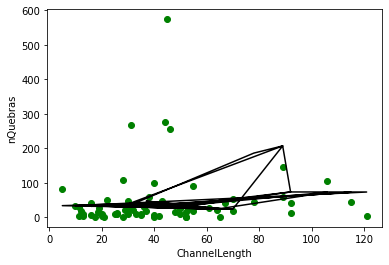

In [92]:
X = dadosB['ChannelLength']
y = dadosB['nQuebras']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
for i in [10,100, 1000]:
    print(i)
    regr = RandomForestRegressor(n_estimators=i, max_depth=2, random_state=0, n_jobs=12)
    regr.fit(X_train.values.reshape(-1, 1), y_train.values.reshape(-1, 1))
    print(r2_score(y_test.values.reshape(-1, 1), regr.predict(X_test.values.reshape(-1, 1))))
    print(mean_squared_error(y_test.values.reshape(-1, 1), regr.predict(X_test.values.reshape(-1, 1))))
    print(calc_rss(y_test.values.reshape(-1, 1), regr.predict(X_test.values.reshape(-1, 1))))
    
plt.scatter(X_test.values.reshape(-1, 1), y_test.values.reshape(-1, 1),color='g')
plt.plot(X_test.values.reshape(-1, 1), regr.predict(X_test.values.reshape(-1, 1)),color='k')
plt.xlabel('ChannelLength')
plt.ylabel('nQuebras')    



In [44]:
parameters = {'n_neighbors':[1, 10]}
knn = KNeighborsRegressor()
clf = GridSearchCV(knn, parameters)
clf.fit(X, y)
print(sorted(clf.cv_results_.keys()))


['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_n_neighbors', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']


/home/vitorbezerra/miniconda3/envs/amb1/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [8]:
#funções utilitárias:

def get(data, coluna): return data.loc[:,[coluna]] #pega a coluna de um conteiner do pandas e retorna um novo DataFrame

def rss(y,predicted):
    return float(((predicted - y) ** 2.0).sum())

def norm(vetor): return vetor/(vetor.max()) #normaliza caso o vetor/variavel tenha o método max()

def calc_rss(y, predicted): return rss( norm (y), norm (predicted)) #normaliza e calcular RSS

def doMatPlotText(texto, x=0.5, y=0.5, cor='red'): plt.text(x,y, texto, horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor=cor, alpha=0.5))
    
def ordemZero(x, s=500): #plota o gráfico da predição interpolando os valores
    return np.linspace(
        min(x.values.ravel()),
        max(x.values.ravel()), s )[:, np.newaxis]

In [9]:
def knn_plotter(xx,yy,dataset, kernel=None, titulo=" "):
    """
    Faz a regressão indicando o objeto em kernel com uma base de dados, a coluna X e a predicao Y

    Keyword arguments:
    xx -- str: variavel independente (nome da coluna da base de dados)
    yy -- str: variavel dependente  (nome da coluna para predicao)
    dataset -- pandas.Dataframe : conjunto de dados do Pandas (requer as series xx e yy), exemplo: KNeighborsRegressor(n_neighbors=3)
    titulo -- str: titulo do grafico (suporta subplot)
    
    """
    (varXnome,varYnome) = (xx , yy)
  
    X_knn, Y_knn = ( get(dataset,varXnome), get(dataset,varYnome) )
    
    KnnModel = kernel 

    KnnModel.fit(X_knn, Y_knn )

    Yp_knn = KnnModel.predict( X_knn )
  
    Yp_knn_interpol = KnnModel.predict( ordemZero( X_knn ) ).flatten()

    knn_rss = 0.0
    
    try: #algumas classes do sklearn não retornam array, e sim uma serie de dados:
        knn_rss = calc_rss(Y_knn, Yp_knn)
    except:
        knn_rss = calc_rss(Y_knn[yy], Yp_knn)
  
    mlabel =  "rss={0:.3f}".format(knn_rss)     #colocar o rss numa legenda do plt   

    plt.plot( X_knn, Y_knn, "db", label="ori."); 
    plt.title(titulo)
    plt.plot(ordemZero( X_knn ), 
             Yp_knn_interpol, "--r", label=mlabel); 
    plt.xlabel(varXnome); plt.ylabel(varYnome);
    plt.legend(); plt.grid();
    

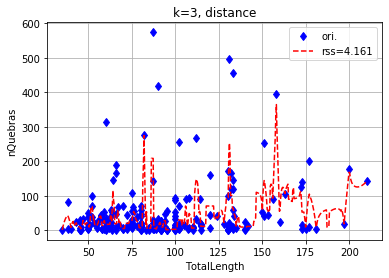

In [10]:
k=3
metodo='distance'
KnnModel = KNeighborsRegressor(n_neighbors=k,weights=metodo)
knn_plotter('TotalLength','nQuebras',dadosB, KnnModel, titulo="k={0}, {1}".format(k,metodo))

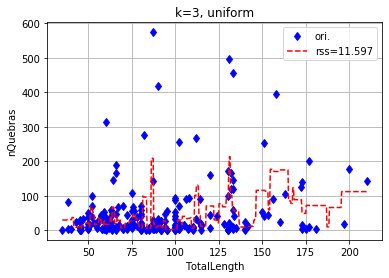

In [11]:
k=3
metodo='uniform'
KnnModel = KNeighborsRegressor(n_neighbors=k,weights=metodo)
knn_plotter('TotalLength','nQuebras',dadosB, KnnModel, titulo="k={0}, {1}".format(k,metodo))